## Mean Curvature Flow

In this example we compute the mean curvature flow of a surface:
\begin{align}
   \frac{\partial}{\partial_t} x &= H(x)  && \text{for } x\in\Gamma(t)
\end{align}
Assume we can define a reference surface $\Gamma_0$ such that
we can write the evolving surface $\Gamma(t)$ in the form
\begin{gather}
  \Gamma(t) = X(t,\Gamma_0)
\end{gather}
It is now possible to show that the vector valued function $X=X(t,x)$ with $x\in\Gamma_0$ satisfies:
\begin{gather}
  \frac{\partial}{\partial_t}X = - H(X)\nu(X)
\end{gather}
where $H$ is the mean curvature of $\Gamma_t$ and $\nu$ is its outward pointing normal.

We will solve this using a finite element approach based on the following time discrete approximation:
\begin{gather}
  \int_{\Gamma^n} \big( U^{n+1} - {\rm id}\big) \cdot \varphi +
    \tau \int_{\Gamma^n} \big(
    \theta\nabla_{\Gamma^n} U^{n+1} + (1-\theta) I \big)
    \colon\nabla_{\Gamma^n}\varphi
  =0~.
\end{gather}
Here $U^n$ parametrizes $\Gamma(t^{n+1})$ over
$\Gamma^n:=\Gamma(t^{n})$,
$I$ is the identity matrix, $\tau$ is the time step and
$\theta\in[0,1]$ is a discretization parameter.
<img src="mcf.gif" style="height:228px;">

In [1]:
from __future__ import print_function
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass

import math

from ufl import *
import dune.ufl
import dune.create as create
import dune.geometry as geometry
import dune.fem as fem
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as pyplot

# polynomial order of surface approximation
order = 2

# initial radius
R0 = 2.

In [2]:
# set up reference domain Gamma_0
grid = create.grid("ALUConform", "sphere.dgf", dimgrid=2, dimworld=3)
# grid.hierarchicalGrid.globalRefine(1)

# space on Gamma_0 to describe position of Gamma(t)
spc = create.space("lagrange", grid, dimrange=grid.dimWorld, order=order)
# non-spherical initial surface
positions = spc.interpolate(lambda x: x * 
                      (1 + 0.5*math.sin(2*math.pi*x[0]*x[1])*
                            math.cos(math.pi*x[2])), name="position")

# space for discrete solution on Gamma(t)
surface   = create.view("geometry",positions)
spc = create.space("lagrange", surface, dimrange=surface.dimWorld, order=order)
solution  = spc.interpolate(lambda x: x, name="solution")

In [3]:
# set up model using theta scheme
theta = 0.5   # Crank-Nicholson

uflSpace = dune.ufl.Space((surface.dimGrid, surface.dimWorld), 
                           surface.dimWorld)
u = TrialFunction(uflSpace)
v = TestFunction(uflSpace)
x = SpatialCoordinate(uflSpace.cell())
I = Identity(3)
tau = Constant(uflSpace.cell())

a = (inner(u - x, v) + tau * inner(theta*grad(u)
    + (1 - theta)*I, grad(v))) * dx
model = create.model("elliptic", surface, a == 0)

scheme = create.scheme("h1", spc, model, solver="cg")

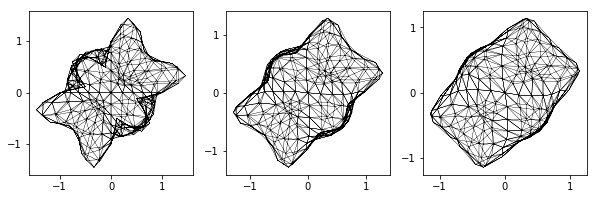

In [5]:
count   = 0
t       = 0.
endTime = 0.05
dt      = 0.005
model.setConstant(tau,dt)

fig = pyplot.figure(figsize=(10,10))
plot(solution, figure=(fig, 131+count%3), colorbar=False, gridLines="", triplot=True)

while t < endTime:
    scheme.solve(target=solution)
    t     += dt
    count += 1
    positions.dofVector.assign(solution.dofVector)
    if count % 4 == 0:
        # surface.writeVTK("mcf"+str(order)+"-0-", pointdata=[solution], number=count)
        # surface.writeVTK("mcf"+str(order)+"-3-", pointdata=[solution], number=count, subsampling=3)
        plot(solution, figure=(fig, 131+count%3), colorbar=False, gridLines="", triplot=True)
pyplot.show()
pyplot.close('all')

In case we start with a spherical initial surface, i.e., $\Gamma(0)=R_0\;S^2$, the solution
to the mean curvature flow equation is easy to compute:
\begin{align}
  \Gamma(t) &= R(t)\;S^2 \\
  R(t) &= \sqrt{R_0^2-4t}
\end{align}
We can use this to check that our implementation is correct:

In [6]:
# compute an averaged radius of the surface
def calcRadius(surface):
    # compute R = int_x |x| / int_x 1
    R   = 0
    vol = 0
    for e in surface.elements:
        rule = geometry.quadratureRule(e.type, 4)
        for p in rule:
            geo = e.geometry
            weight = geo.volume * p.weight
            R   += geo.toGlobal(p.position).two_norm * weight
            vol += weight
    return R/vol

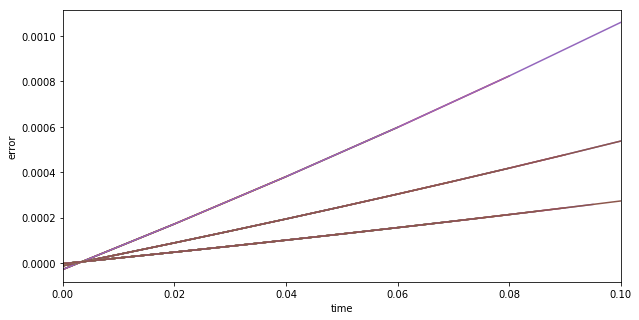

In [7]:
endTime = 0.1
dt      = 0.02

import numpy as np
pyplot.figure()
pyplot.gca().set_xlim([0, endTime])
pyplot.gca().set_ylabel("error")
pyplot.gca().set_xlabel("time")

numberOfLoops = 3
errors = np.zeros(numberOfLoops)
totalIterations = np.zeros(numberOfLoops, np.dtype(np.uint32))
gridSizes = np.zeros(numberOfLoops, np.dtype(np.uint32))
for i in range(numberOfLoops):
    positions.interpolate(lambda x: x * (R0/x.two_norm))
    solution.interpolate(lambda x: x)
    t = 0.
    R = calcRadius( surface )
    Rexact = math.sqrt(R0*R0 - 4.*t)
    x = np.array([t])
    y = np.array([R - Rexact])
    model.setConstant(tau, dt)
    iterations = 0
    while t < endTime:
        solution,info = scheme.solve(target=solution)
        # move the surface
        positions.dofVector.assign(solution.dofVector)
        # store some information about the solution process
        iterations += int( info["linear_iterations"] )
        t          += dt
        R      = calcRadius( surface )
        Rexact = math.sqrt(R0*R0-4.*t)
        # print("R_h=",R, "Rexact=",Rexact, "difference=",R-Rexact)
        x = np.append(x, [t])
        y = np.append(y, [R - Rexact])
        pyplot.plot(x, y)
        display.clear_output(wait=True)
        display.display(pyplot.gcf())
    errors[i] = abs(R-Rexact)
    totalIterations[i] = iterations
    gridSizes[i] = grid.size(2)
    if i < numberOfLoops - 1:
        grid.hierarchicalGrid.globalRefine(1)
        dt /= 2.

In [8]:
eocs = np.log(errors[0:][:numberOfLoops-1] / errors[1:]) / math.log(2.)
print(eocs)

[ 0.82367599  1.13075244]


In [9]:
try:
    import pandas as pd
    keys = {'size': gridSizes, 'error': errors, "eoc": np.insert(eocs, 0, None), 'iterations': totalIterations}
    table = pd.DataFrame(keys, index=range(numberOfLoops),columns=['size', 'error', 'eoc', 'iterations'])
    print(table)
except ImportError:
    print("pandas could not be used to show table with results")
    pass

   size     error       eoc  iterations
0   318  0.001060       NaN          65
1   854  0.000599  0.823676         249
2  2065  0.000274  1.130752         520
